In [432]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit.library import StatePreparation
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram, plot_state_city
from qiskit.circuit.library import QFT

def add_constant(n_qubits: int, c: int) -> QuantumCircuit:
    """Returns a circuit that maps |x⟩ → |(x + c) mod 2^n⟩."""
    qc = QuantumCircuit(n_qubits, name=f"+{c}")
    qc.append(QFT(n_qubits, do_swaps=False), range(n_qubits))
    for k in range(n_qubits):
        angle = 2 * np.pi * c / (2 ** (k + 1))
        qc.p(angle, k)          # P(θ)|0⟩=|0⟩, P(θ)|1⟩=e^{iθ}|1⟩

    qc.append(QFT(n_qubits, do_swaps=False, inverse=True), range(n_qubits))

    return qc

def prepare_sto_state(n_qubits: int, a: float) -> QuantumCircuit:
    """Returns a circuit that prepares the state |ψ⟩ = N · Σ e^(-a·|i|) |i⟩."""
    qc = QuantumCircuit(n_qubits)
    last_qubit = n_qubits - 1

    qc.h(last_qubit)
    #qc.x(last_qubit)

    b = a
    for i in range(n_qubits-1):
        theta = 2 * np.arctan(np.exp(b))
        qc.cry(theta, last_qubit, i)
        b = b * 2
    qc.x(last_qubit)

    b = a
    for i in range(n_qubits-1):
        theta = 2 * np.arctan(np.exp(-b))
        qc.cry(theta, last_qubit, i)
        b = b * 2

    qc.x(last_qubit)

    return qc


def sto(n_qubits: int, a: float, center: int) -> QuantumCircuit:
    """Returns a circuit that prepares the state |ψ⟩ = N · Σ e^(-a·|i-center|) |i-center⟩."""
    qc = QuantumCircuit(n_qubits)
    qc.compose(prepare_sto_state(n_qubits, a), inplace=True)
    qc.compose(add_constant(n_qubits, center), inplace=True)

    return qc

C:\Users\sorin\AppData\Local\Temp\ipykernel_34708\2622932181.py:13: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits, do_swaps=False), range(n_qubits))
C:\Users\sorin\AppData\Local\Temp\ipykernel_34708\2622932181.py:18: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits, do_swaps=False, inverse=True), range(n_qubits))


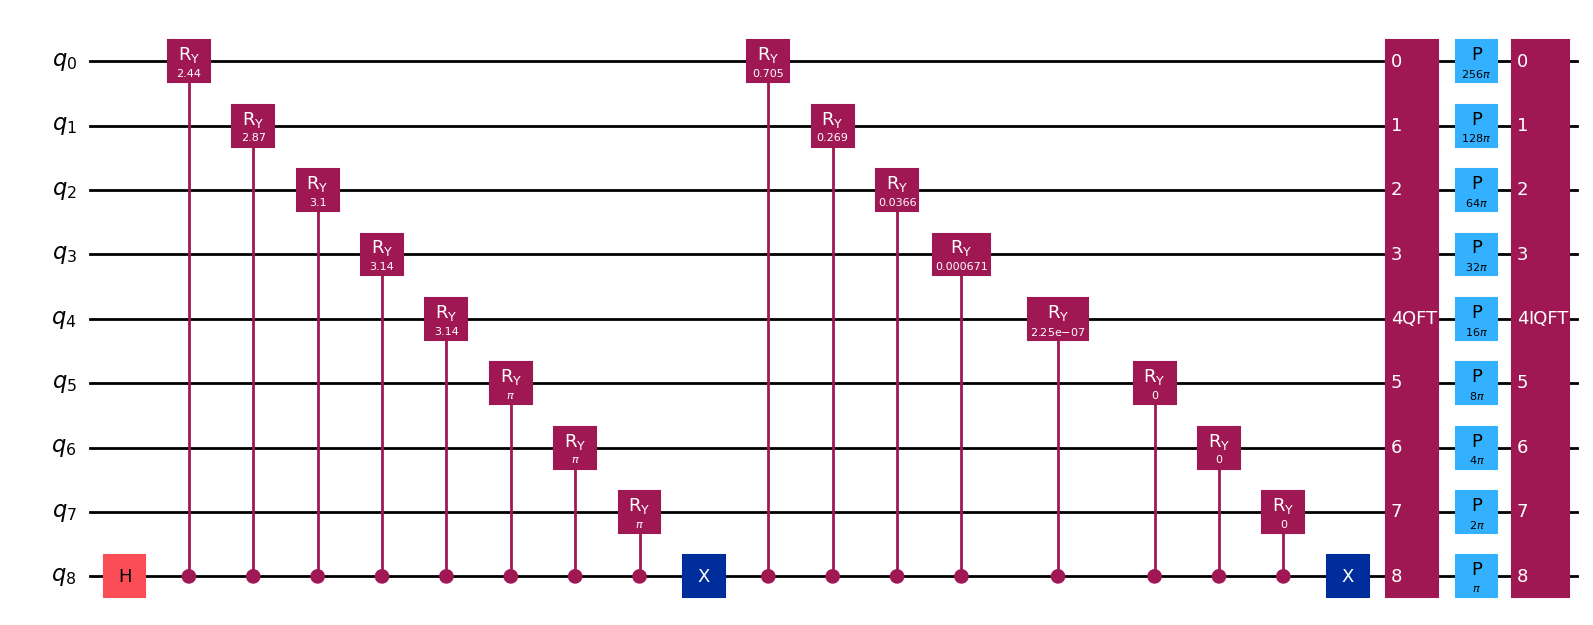

In [487]:
# Decaying exponential state: |ψ⟩ = N · Σ e^(-a·i) |i⟩  for i = 0 … 2^4-1
a = 1  # decay constant
n_qubits = 9
center1 = 2**(n_qubits-1)
center2 = 150

#theta = 2 * np.arctan(np.exp(-a))

qc = sto(n_qubits, a, center1)

qc.draw('mpl', style='iqp')


In [488]:
# Simulate the statevector using Qiskit's local statevector simulator
sv = Statevector(qc)

print("Statevector amplitudes (|basis⟩ : amplitude):")
for i, amp in enumerate(sv.data):
    basis = format(i, f'0{n_qubits}b')
    if abs(amp) > 1e-6:
        print(f"  |{basis}⟩ : {amp:.4f}  (prob = {abs(amp)**2:.4f})")


Statevector amplitudes (|basis⟩ : amplitude):
  |011110010⟩ : 0.0000+0.0000j  (prob = 0.0000)
  |011110011⟩ : 0.0000+0.0000j  (prob = 0.0000)
  |011110100⟩ : 0.0000+0.0000j  (prob = 0.0000)
  |011110101⟩ : 0.0000+0.0000j  (prob = 0.0000)
  |011110110⟩ : 0.0001+0.0000j  (prob = 0.0000)
  |011110111⟩ : 0.0002+0.0000j  (prob = 0.0000)
  |011111000⟩ : 0.0006+0.0000j  (prob = 0.0000)
  |011111001⟩ : 0.0016+0.0000j  (prob = 0.0000)
  |011111010⟩ : 0.0044-0.0000j  (prob = 0.0000)
  |011111011⟩ : 0.0120-0.0000j  (prob = 0.0001)
  |011111100⟩ : 0.0327-0.0000j  (prob = 0.0011)
  |011111101⟩ : 0.0890-0.0000j  (prob = 0.0079)
  |011111110⟩ : 0.2419-0.0000j  (prob = 0.0585)
  |011111111⟩ : 0.6575-0.0000j  (prob = 0.4323)
  |100000000⟩ : 0.6575-0.0000j  (prob = 0.4323)
  |100000001⟩ : 0.2419-0.0000j  (prob = 0.0585)
  |100000010⟩ : 0.0890-0.0000j  (prob = 0.0079)
  |100000011⟩ : 0.0327-0.0000j  (prob = 0.0011)
  |100000100⟩ : 0.0120-0.0000j  (prob = 0.0001)
  |100000101⟩ : 0.0044-0.0000j  (prob = 0.

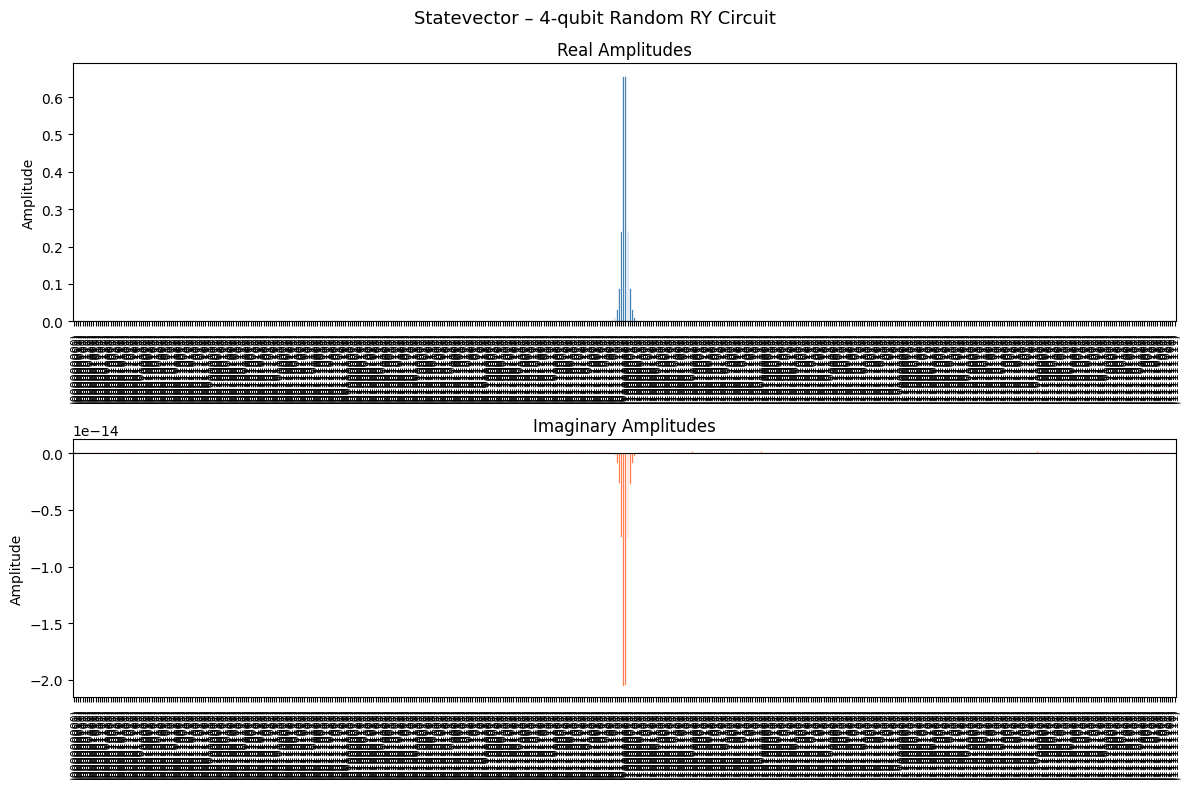

In [489]:

# Visualize statevector: two vertical bar charts stacked (real on top, imaginary below)
n_states = 2 ** n_qubits
basis_labels = [format(i, f'0{n_qubits}b') for i in range(n_states)]
real_parts = sv.data.real
imag_parts = sv.data.imag

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
fig.suptitle("Statevector – 4-qubit Random RY Circuit", fontsize=13)

x = np.arange(n_states)

ax1.bar(x, real_parts, color='steelblue', edgecolor='white', linewidth=0.5)
ax1.axhline(0, color='black', linewidth=0.8)
ax1.set_title("Real Amplitudes")
ax1.set_xticks(x)
ax1.set_xticklabels([f'|{b}⟩' for b in basis_labels], rotation=90, fontsize=8)
ax1.set_ylabel("Amplitude")
ax1.set_xlim(-0.5, n_states - 0.5)

ax2.bar(x, imag_parts, color='coral', edgecolor='white', linewidth=0.5)
ax2.axhline(0, color='black', linewidth=0.8)
ax2.set_title("Imaginary Amplitudes")
ax2.set_xticks(x)
ax2.set_xticklabels([f'|{b}⟩' for b in basis_labels], rotation=90, fontsize=8)
ax2.set_ylabel("Amplitude")
ax2.set_xlim(-0.5, n_states - 0.5)

plt.tight_layout()
plt.show()


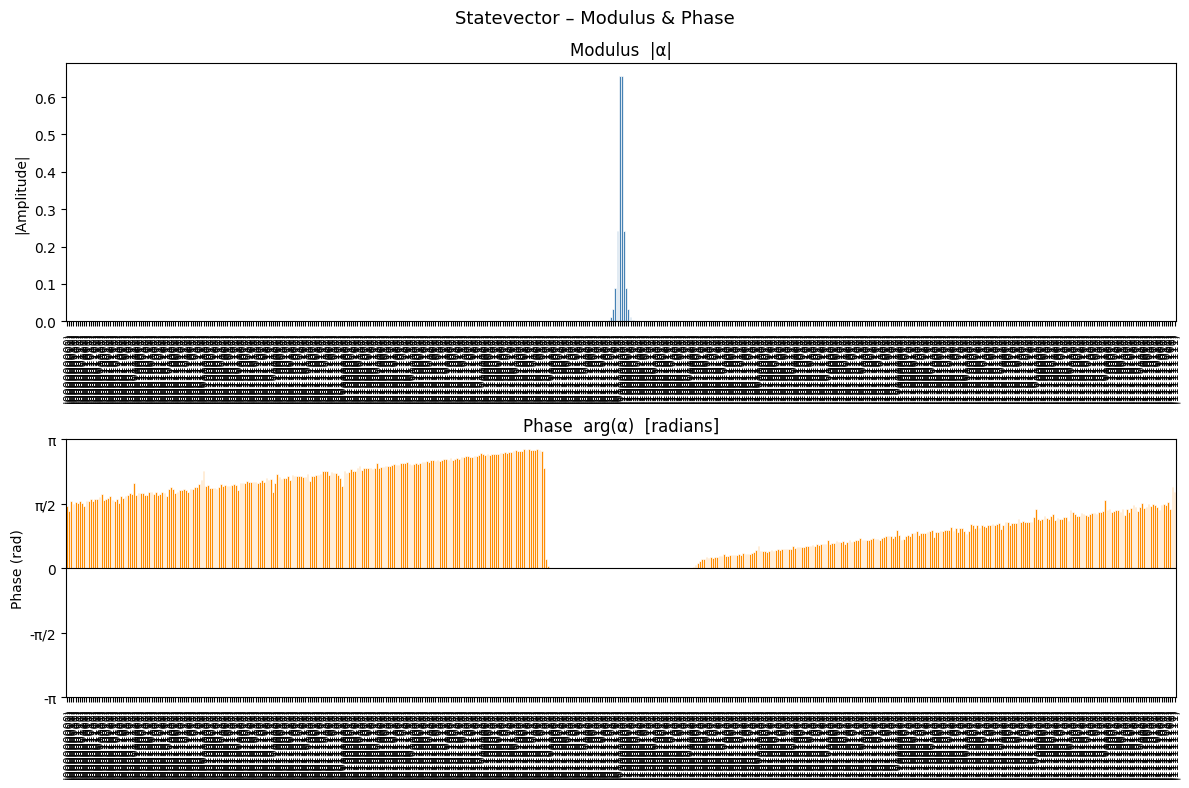

In [490]:
# Visualize statevector: modulus and phase stacked vertically
modulus = np.abs(sv.data)
phase = np.angle(sv.data)   # radians in (-π, π]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
fig.suptitle("Statevector – Modulus & Phase", fontsize=13)

x = np.arange(n_states)
tick_labels = [f'|{b}⟩' for b in basis_labels]

ax1.bar(x, modulus, color='steelblue', edgecolor='white', linewidth=0.5)
ax1.set_title("Modulus  |α|")
ax1.set_xticks(x)
ax1.set_xticklabels(tick_labels, rotation=90, fontsize=8)
ax1.set_ylabel("|Amplitude|")
ax1.set_xlim(-0.5, n_states - 0.5)
ax1.set_ylim(bottom=0)

ax2.bar(x, phase, color='darkorange', edgecolor='white', linewidth=0.5)
ax2.axhline(0, color='black', linewidth=0.8)
ax2.set_title("Phase  arg(α)  [radians]")
ax2.set_xticks(x)
ax2.set_xticklabels(tick_labels, rotation=90, fontsize=8)
ax2.set_ylabel("Phase (rad)")
ax2.set_xlim(-0.5, n_states - 0.5)
ax2.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax2.set_yticklabels(['-π', '-π/2', '0', 'π/2', 'π'])

plt.tight_layout()
plt.show()


Measurement results (1024 shots):
  |011100⟩ :    4  
  |011101⟩ :    8  
  |011110⟩ :   71  ██
  |011111⟩ :  417  ████████████████
  |100000⟩ :  456  █████████████████
  |100001⟩ :   57  ██
  |100010⟩ :   11  


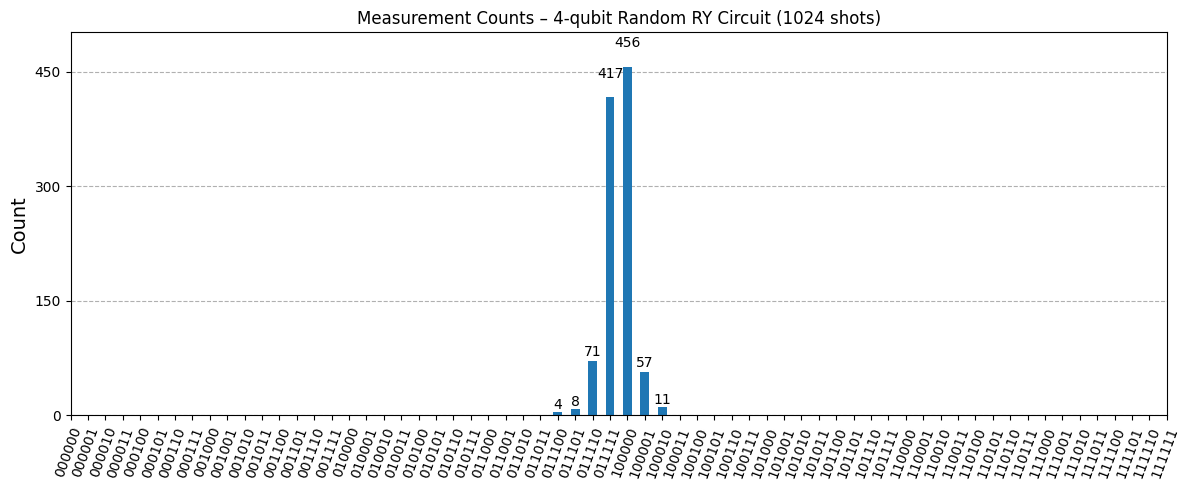

In [486]:
# Sample the statevector to get measurement counts (local simulator)
shots = 1024
counts = sv.sample_counts(shots)

print(f"Measurement results ({shots} shots):")
for state in sorted(counts.keys()):
    bar = '█' * int(counts[state] / shots * 40)
    print(f"  |{state}⟩ : {counts[state]:4d}  {bar}")

# Include all 2^n basis states (zeros for unobserved states)
all_basis = [format(i, f'0{n_qubits}b') for i in range(2 ** n_qubits)]
counts_full = {b: counts.get(b, 0) for b in all_basis}

# Plot histogram of sample counts
fig = plot_histogram(
    counts_full,
    title=f"Measurement Counts – 4-qubit Random RY Circuit ({shots} shots)",
    figsize=(12, 5),
    bar_labels=True,
)
fig.tight_layout()
display(fig)
